In [44]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [45]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, train_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import get_environment
from lib.environments.kolmogorov import KolmogorovEnvironment4, KolmogorovEnvironment5
from lib.policy import get_rl_algo
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
from lib.models import FcNN, MyFCNNActorProb

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs

#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

ImportError: cannot import name 'train_episode' from 'tianshou.trainer.utils' (/home/pfischer/.miniforge3/envs/xlb2/lib/python3.10/site-packages/tianshou/trainer/utils.py)

In [46]:
def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default="CartPole-v1")
    parser.add_argument("--model", type=str, default="ppo")
    parser.add_argument("--reward_threshold", type=int, default=500)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--buffer_size", type=int, default=20000)
    parser.add_argument("--max_epoch", type=int, default=10)
    parser.add_argument("--step_per_epoch", type=int, default=100)
    parser.add_argument("--train_num", type=int, default=1)
    parser.add_argument("--test_num", type=int, default=1)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--gamma", type=float, default=0.90)
    parser.add_argument("--lr", help='learning rate', type=float, default=1e-4)
    parser.add_argument("--repeat_per_collect", type=int, default=1)
    parser.add_argument("--episode_per_test", type=int, default=1)
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--step_per_collect", type=int, default=200) 
    return parser.parse_known_args()[0]


def create_env(kwargs1, kwargs2, min_a=-1., max_a=1., step_factor=10, max_t=100):
    """
    creates the environemnt and applyes wrappers to action and
    observations space and sets time limit.
    """
    env = KolmogorovEnvironment4(kwargs1, kwargs2, step_factor=step_factor, max_episode_steps=max_t)
    #env = TransformObservation(env, lambda obs: (obs/15))
    #env = TimeLimit(env, max_episode_steps=max_t)
    return env


In [47]:
#######################################################################################################
####### setup stuff *##################################################################################
#######################################################################################################
args = get_args()
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
#restrict_to_num_threads(1)

In [48]:
#######################################################################################################
####### environments ##################################################################################
#######################################################################################################
u0_path = "/home/pfischer/XLB/vel_init/velocity_burn_in_1806594.npy" #4096x4096 simulation
rho0_path = "/home/pfischer/XLB/vel_init/density_burn_in_1806594.npy" #4096x4096 simulation
kwargs1, T1,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #cgs 
kwargs2, T2,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #fgs
step_factor=10
#check if cgs time is a factor of fgs time
assert (T2%T1 == 0)
env = create_env(kwargs1, kwargs2, step_factor=step_factor,  max_t=100)
train_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2, step_factor=step_factor, max_t=100) for _ in range(args.train_num)])
test_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2, step_factor=step_factor, max_t=100) for _ in range(args.train_num)])
#check_env(env)

m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0
m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0


step=0
1.0


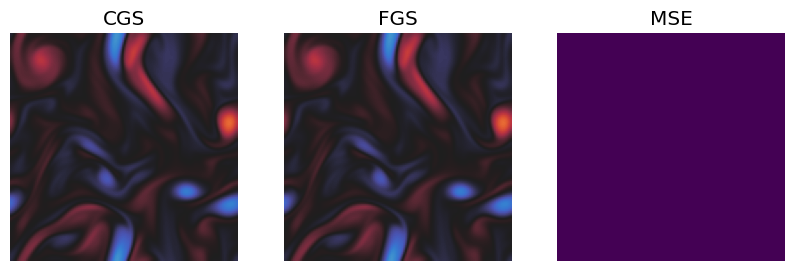

step=25
0.9871399410944357


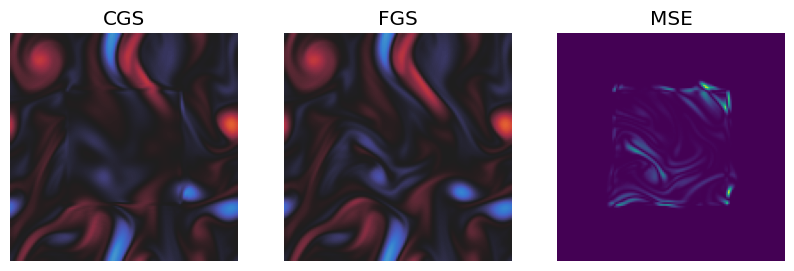

step=50
0.9772873312470434


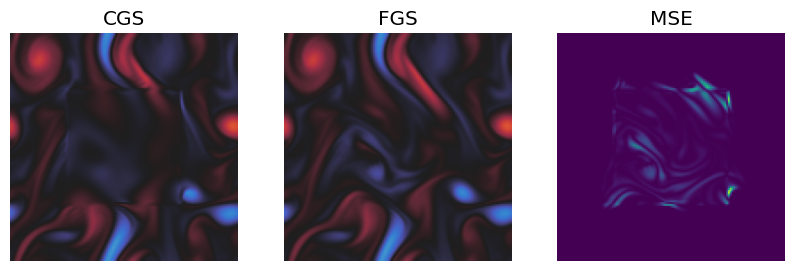

step=75
0.9698735876270129


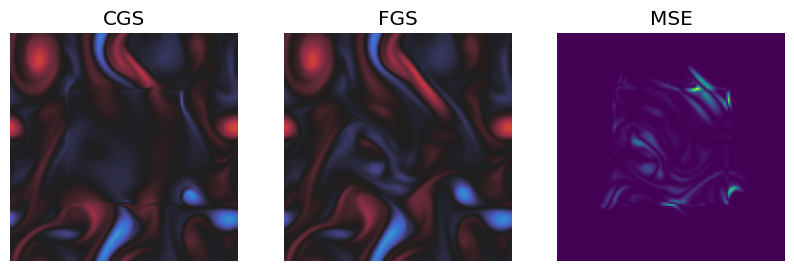

In [49]:
# play one episode and get the max and min vorticity value
obs, inf = env.reset()
alphas = np.ones(env.action_space.shape)
alphas[32:96, 32:96] = 0.92
maxs = []
mins = []
for i in range(100):
    if i%25==0:
        print(f"step={i}")
        env.render()
    #out = env.step(np.array([alphas]))
    out = env.step(alphas)
    obs = out[0]
    #print(obs)
    maxs.append(obs.max())
    mins.append(obs.min())
env.close()

step=0
1.0


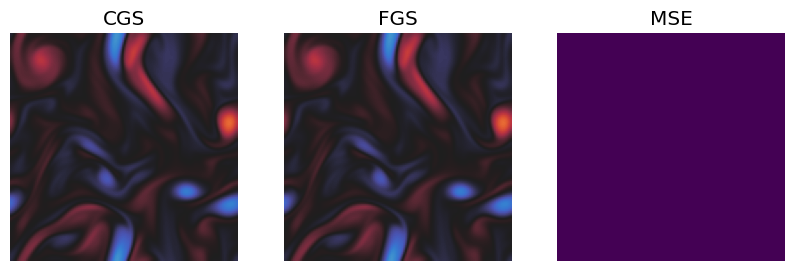

step=100
0.9640863667446604


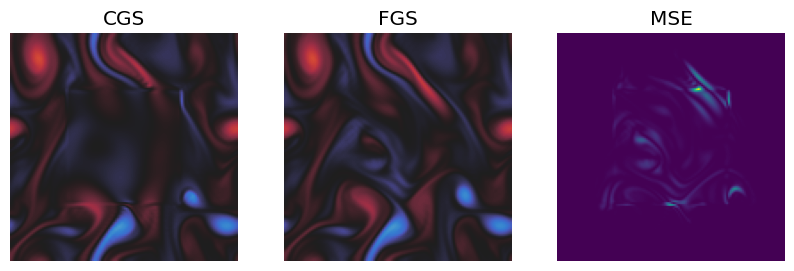

step=200
0.9229908476407197


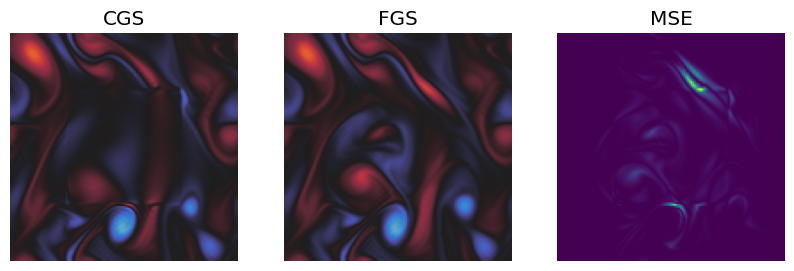

step=300
0.8561953279970064


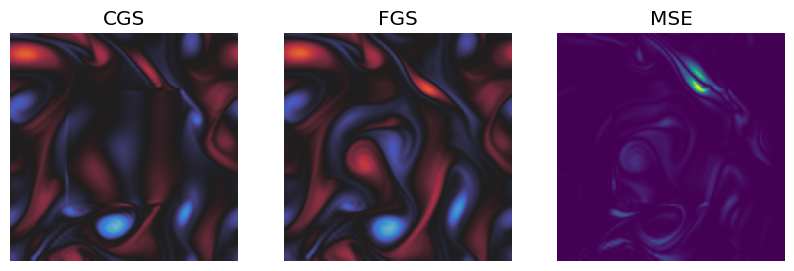

step=400
0.7169008593184827


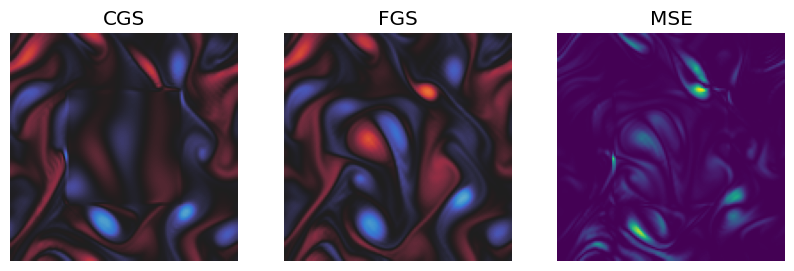

step=500
0.5875728186445051


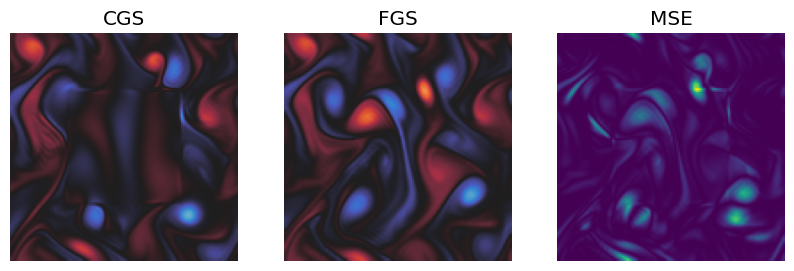

step=600
0.5438812967416964


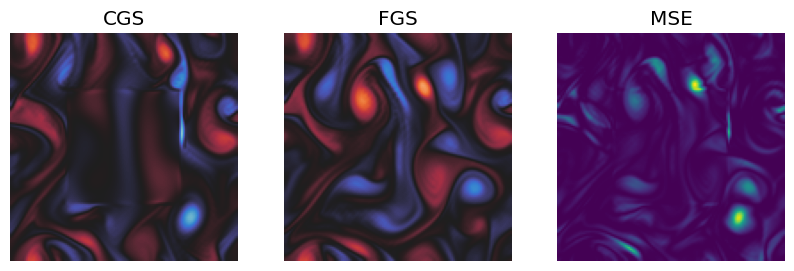

step=700
0.4277146796462741


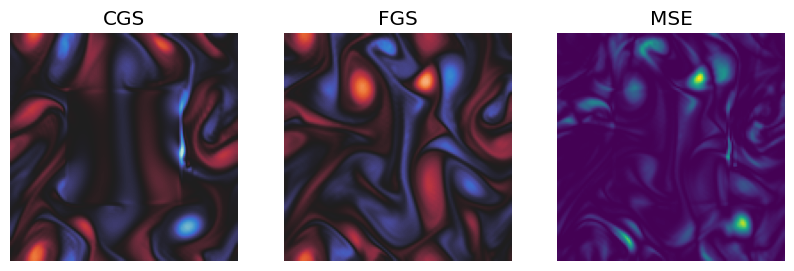

step=800
0.37252929877031776


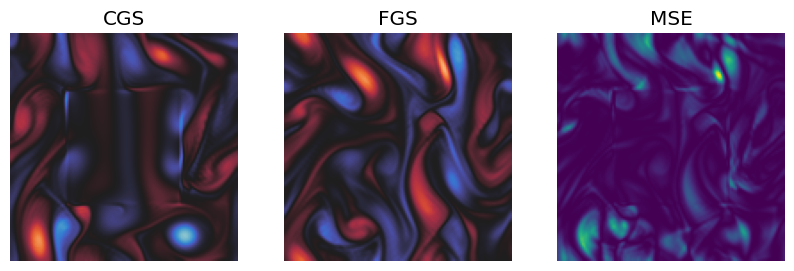

step=900
0.19418433518939623


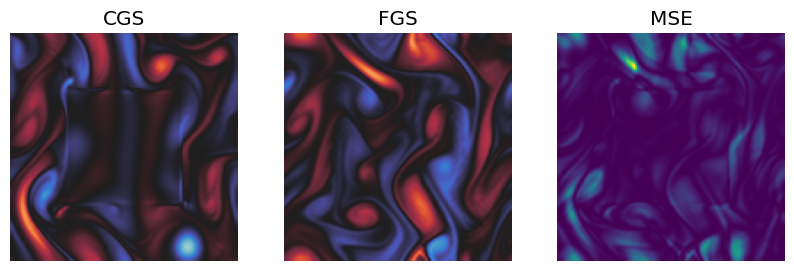

In [50]:
# play one episode and get the max and min vorticity value
obs, inf = env.reset()
alphas = np.ones(env.action_space.shape)
alphas[32:96, 32:96] = 0.92
maxs = []
mins = []
for i in range(1000):
    if i%100==0:
        print(f"step={i}")
        env.render()
    #out = env.step(np.array([alphas]))
    out = env.step(alphas)
    obs = out[0]
    #print(obs)
    maxs.append(obs.max())
    mins.append(obs.min())
env.close()

In [51]:
print(np.max(maxs))
print(np.min(mins))

17.11710106887146
-23.0041716601359


# Levels of abstaction of Reinforce

In [54]:
#Policy
actor = MyFCNNActorProb(env.action_space.shape, device=device).to(device)
optim = torch.optim.AdamW(actor.parameters(), lr=0.0001)
dist = torch.distributions.Normal
policy = PGPolicy(model=actor,optim=optim, dist_fn=dist, action_space=env.action_space,
    discount_factor=0.97,reward_normalization=False, deterministic_eval=False,
    observation_space=env.observation_space, action_scaling=True, action_bound_method = "tanh",
)

#Collectors
train_collector = Collector(policy=policy,env=train_env,buffer=VectorReplayBuffer(20000, len(train_env)))
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()

#trainer
t = OnpolicyTrainer(policy=policy, train_collector=train_collector, test_collector=test_collector,
    max_epoch=2, step_per_epoch=100, repeat_per_collect=1, episode_per_test=1, batch_size=16,
    episode_per_collect=1, show_progress=True #stop_fn=lambda mean_reward: mean_reward >= -200,
)

bias is initialized to Parameter containing:
tensor([0.1154], requires_grad=True)


In [10]:
#load trained bolicy
policy.load_state_dict(torch.load('dump/GlobOmegLocAct_3.pth'))

<All keys matched successfully>

## Play one episode

In [55]:
# visualize policy

In [56]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = env.reset()
act_means = []
act_maxs = []
act_mins = []
std_means = []
episode_is_over = False
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    #act_means.append(logits[0].reshape(128,128).mean())
    #act_mins.append(logits[0].reshape(128,128).min())
    #act_maxs.append(logits[0].reshape(128,128).max())
    act_means.append(act.reshape(128,128).mean())
    act_mins.append(act.reshape(128,128).min())
    act_maxs.append(act.reshape(128,128).max())
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = env.step(act)
    reward += rew
    step += 1
    if step%10==0:
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        print(logits[0].mean(), logits[1].mean(), action.mean(), act.mean())
        env.render()
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward}")
env.close()

terminated
#steps = 4, Total Reward = 0.30030594255144516


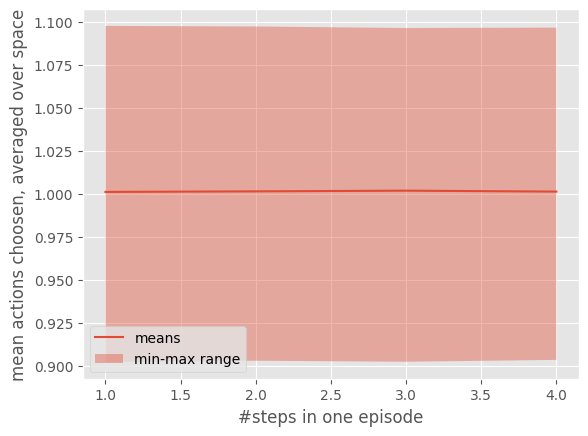

In [57]:
#this plots the mean, max and min of actions computed over space as a plot over the time of one episode
t = np.linspace(1, len(act_means),len(act_means))
plt.figure()
plt.plot(t, act_means, label="means")
plt.fill_between(t, act_mins, act_maxs, alpha=0.4, label="min-max range")
#plt.plot(t, act_mins, label="mins")
#plt.plot(t, act_maxs, label="maxs")
#plt.ylim([0.9,1.1])
plt.legend()
plt.xlabel("#steps in one episode")
plt.ylabel("mean actions choosen, averaged over space")
plt.show()

In [58]:
obs, inf = env.reset()
mean, std = policy(Batch(obs=np.array([obs]), info={})).logits.detach().cpu().numpy()
mean, std = mean.reshape(128,128), std.reshape(128,128)

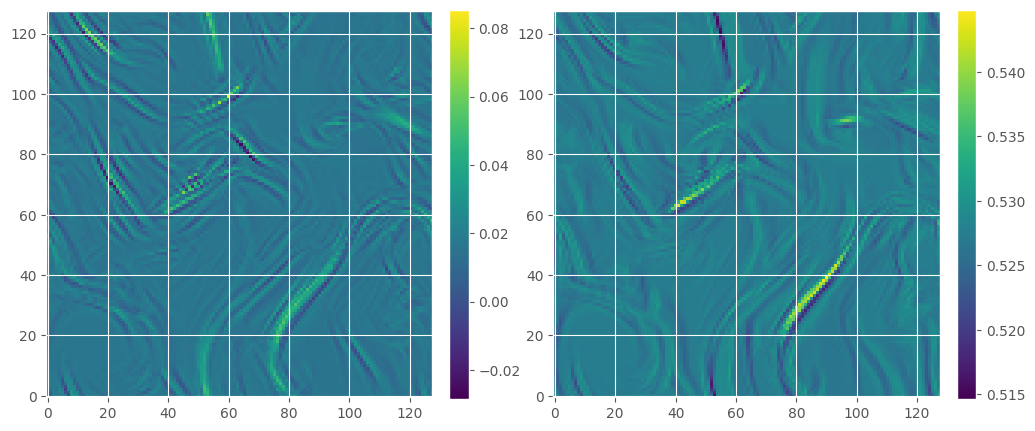

In [59]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal', origin='lower')
im2 = axs[1].imshow(std, cmap='viridis', aspect='equal', origin='lower')
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
plt.show()

In [60]:
def train_step():
        """Perform one training step."""
        assert trainer.episode_per_test is not None
        assert trainer.train_collector is not None
        stop_fn_flag = False

        #what does train_fn do?
        if trainer.train_fn:
            trainer.train_fn(trainer.epoch, trainer.env_step)

        #collect either step_per_collect or episode_per_collect results
        result = trainer.train_collector.collect(n_step=trainer.step_per_collect, n_episode=trainer.episode_per_collect)

        #transforms rewards
        if result["n/ep"] > 0 and trainer.reward_metric:
            rew = trainer.reward_metric(result["rews"]) #seems to apply the reward_metric ontop of the collected rewards
            result.update(rews=rew, rew=rew.mean(), rew_std=rew.std())

        trainer.env_step += int(result["n/st"]) #n/st measures the total number of steps taken in the environment
        trainer.logger.log_train_data(result, trainer.env_step) #logs training data
        trainer.last_rew = result["rew"] if result["n/ep"] > 0 else trainer.last_rew #updates last reward if a whole episode was played
        trainer.last_len = result["len"] if result["n/ep"] > 0 else trainer.last_len #updates last length if a whole episode was played

        #updated printed statistics of the call to train_step
        data = {
            "env_step": str(trainer.env_step),
            "rew": f"{trainer.last_rew:.2f}",
            "len": str(int(trainer.last_len)),
            "n/ep": str(int(result["n/ep"])),
            "n/st": str(int(result["n/st"])),
        }

        if result["n/ep"] > 0:
            #if stop_fn returns true on training data we perform a test and check if stop_fn also
            #returns true on testing data. If so, we stop everything by setting stop_fn_flag = True
            if trainer.test_in_train and trainer.stop_fn and trainer.stop_fn(result["rew"]):
                assert trainer.test_collector is not None
                test_result = test_episode(
                    trainer.policy, trainer.test_collector, trainer.test_fn, trainer.epoch,
                    trainer.episode_per_test, trainer.logger, trainer.env_step
                )

                if trainer.stop_fn(test_result["rew"]):
                    stop_fn_flag = True
                    trainer.best_reward = test_result["rew"]
                    trainer.best_reward_std = test_result["rew_std"]
                else:
                    trainer.policy.train()

        # returns results of training, not of testing!
        return data, result, stop_fn_flag

In [61]:
epochs = 2
step_per_epoch = 100
global_iter_num = 1 #counts what? -> total number of iterations with the environment
stop_fn_flag = False #should be set to true if stop_fn otputs true
show_progress = True #flag indicating the visualization of a progress bar
train_rew = []
train_rew_std = []
test_rew = []
test_rew_std = []
train_len = []
train_len_std = []
test_len = []
test_len_std = []
steps = []


In [62]:
trainer.reset()
for epoch in range(1,epochs+1):
    """Perform one epoch (both train and eval)."""
    global_iter_num += 1
    trainer.epoch+=1
    if global_iter_num > 1:
        # exit flag 1, when stop_fn succeeds in train_step or test_step
        if stop_fn_flag:
            print("stop iteration due to stop_fn_flag")
            break
    
    policy.train() #set policy in train mode
    epoch_stat = dict() #dictionary to save epoch statistics


    # perform n step_per_epoch
    progress = tqdm if show_progress else DummyTqdm
    with progress(total=step_per_epoch, desc=f"Epoch #{epoch}") as t:
        while t.n < t.total and not stop_fn_flag:
            data = dict()
            result = dict()
            #********************************************************************************************************************
            #PERFORM A COLLECT STEP *********************************************************************************************
            #********************************************************************************************************************
            if trainer.train_collector is not None:
                data, result, stop_fn_flag = train_step()
                t.update(result["n/st"]) #updates the counter t with the total number of steps taken in the last train_step update!
                if trainer.stop_fn_flag:
                    t.set_postfix(**data) #sets print output of progress bar
                    break #breaks while loop in case stop_fn is true

                # save training results **********************************
                train_rew.append(result["rew"])
                train_rew_std.append(result["rew_std"])
                train_len.append(result["len"])
                train_len_std.append(result["len_std"])
                steps.append(result["n/st"])
            #********************************************************************************************************************
            #********************************************************************************************************************
            #********************************************************************************************************************
            else:
                print("WARNING: o train_collector was found")
                assert trainer.buffer, "No train_collector or buffer specified"
                result["n/ep"] = len(trainer.buffer)
                result["n/st"] = int(trainer.gradient_step)
                t.update()

            #********************************************************************************************************************
            #PERFORM A POLICY UPDATE ********************************************************************************************
            #********************************************************************************************************************
            #updates the policy with the collected data and results 
            trainer.policy_update_fn(data, result)
            t.set_postfix(**data)
            #********************************************************************************************************************
            #********************************************************************************************************************
            #********************************************************************************************************************


    # for offline RL
    if trainer.train_collector is None:
        trainer.env_step = trainer.gradient_step * trainer.batch_size
    
    # loggs training data if stop_fn_flag is not true jet, hence logs testing stats after each epoch
    if not trainer.stop_fn_flag:
        trainer.logger.save_data(trainer.epoch, trainer.env_step, trainer.gradient_step, trainer.save_checkpoint_fn)
        #********************************************************************************************************************
        # PERFORM A TESTING STEP ********************************************************************************************
        #********************************************************************************************************************
        if trainer.test_collector is not None:
            test_stat, trainer.stop_fn_flag = trainer.test_step()
            if not trainer.is_run: #if trainer isn't running 
                epoch_stat.update(test_stat)

            # save testing results 
            test_rew.append(test_stat["test_reward"])
            test_rew_std.append(test_stat["test_reward_std"])
        #********************************************************************************************************************
        #********************************************************************************************************************
        #********************************************************************************************************************
        

    # if trainer is not running -> meaning logs training stats after each epoch if trainer has finished
    # gets called very little  
    if not trainer.is_run:
        epoch_stat.update({k: v.get() for k, v in trainer.stat.items()})
        epoch_stat["gradient_step"] = trainer.gradient_step
        epoch_stat.update(
            {
                "env_step": trainer.env_step,
                "rew": trainer.last_rew,
                "len": int(trainer.last_len),
                "n/ep": int(result["n/ep"]),
                "n/st": int(result["n/st"]),
            }
        )
        info = gather_info(
            trainer.start_time, trainer.train_collector, trainer.train_collector,
            trainer.best_reward, trainer.best_reward_std
        )
        print("return")
        #TODO: do something with the info here -> or just return it

    else:
        print("no return cause trainer is still running")

Epoch #1: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s, env_step=100, len=4, loss=0.365, n/ep=1, n/st=4, rew=1.66]


Epoch #1: test_reward: 1.483368 ± 0.000000, best_reward: 1.483368 ± 0.000000 in #1
return


Epoch #2: 100%|██████████| 100/100 [01:40<00:00,  1.00s/it, env_step=200, len=4, loss=0.365, n/ep=1, n/st=4, rew=1.60]


Epoch #2: test_reward: 1.408689 ± 0.000000, best_reward: 1.483368 ± 0.000000 in #1
return


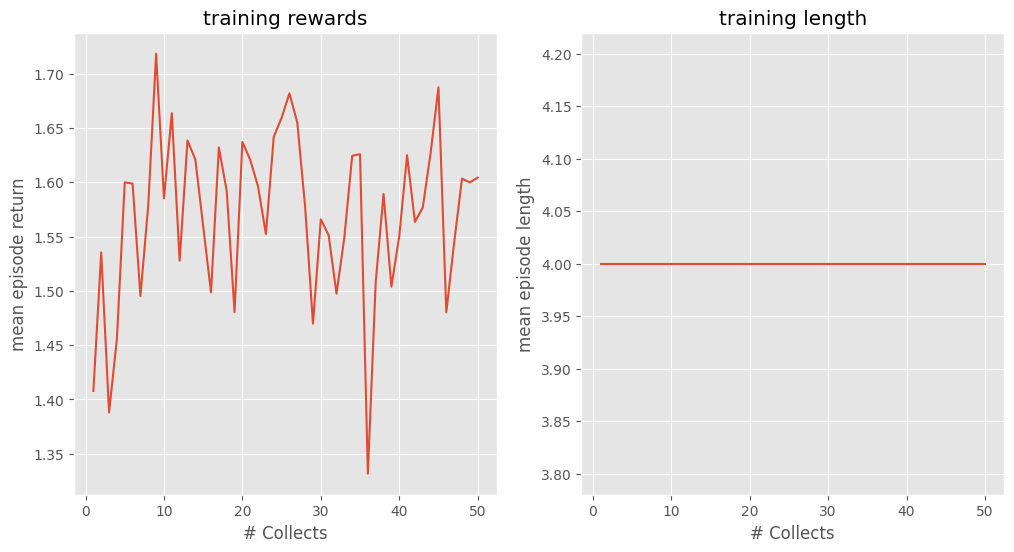

In [66]:
# plot training rewards
time = np.linspace(1, len(train_rew), len(train_rew))
train_rew = np.array(train_rew)
train_rew_std = np.array(train_rew_std)
train_len = np.array(train_len)
tain_len_std = np.array(train_len_std)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title("training rewards")
axs[0].plot(time, train_rew)
axs[0].fill_between(time, train_rew-train_rew_std, train_rew+train_rew_std, alpha=0.4)
axs[0].set_xlabel("# Collects")
axs[0].set_ylabel("mean episode return")
axs[1].set_title("training length")
axs[1].plot(time, train_len)
axs[1].fill_between(time, train_len-train_len_std, train_len+train_len_std, alpha=0.4)
axs[1].set_xlabel("# Collects")
axs[1].set_ylabel("mean episode length")
plt.show()


In [ ]:
env.close()
train_env.close()
test_env.close()
trainer.reset()